## LightGBM

In [17]:
import pandas as pd
import numpy as np

import lightgbm as lgbm

In [66]:
df = pd.read_csv('/workspace/kaggle_data/train.csv')
df = df.drop('full_text',axis = 1)
df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5


In [67]:
df3 = pd.read_csv('/workspace/kaggle_data/seed.csv')
df3.head()

,text_id,fold
0,0016926B079C,2
1,0022683E9EA5,0
2,00299B378633,1
3,003885A45F42,3
4,0049B1DF5CCC,3


In [68]:
df1 = pd.read_csv('/workspace/kaggle_data/conventions_eda_data.csv')
df1.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,miss_count,bos_count,week_months,small_count,miss_rate,small_rate,log_miss_rate,log_small_rate,sample
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,262,0,15,0,15,0.000000,0.057252,0.000000,0.055673,0.055673
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,1,4,0,4,0.001876,0.007505,0.001874,0.007477,0.010288
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,4,2,0,2,0.012500,0.006250,0.012423,0.006231,0.024864
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,727,1,2,0,2,0.001376,0.002751,0.001375,0.002747,0.004809
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,7,0,0,0,0.029915,0.000000,0.029476,0.000000,0.044214


In [69]:
df2 = pd.read_csv('/workspace/kaggle_data/DeBERTa-best/fold0.csv')
df2.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.185547,3.343750,3.246094,3.458984,3.369141,3.041016
1,2.638672,2.666016,2.943359,2.599609,2.441406,2.775391
2,2.939453,3.039062,3.048828,3.005859,3.058594,3.039062
3,3.912109,3.730469,3.878906,3.707031,3.699219,3.781250
4,2.572266,2.509766,2.777344,2.564453,2.486328,2.435547


In [70]:
df5 = pd.read_csv('/workspace/kaggle_data/mistake_features.csv')
df5.head()

,style,whitespace,locale-violation,misspelling,typographical,inconsistency,duplication,uncategorized,grammar_mistakes,error_length,sum_mistakes
0,0,1,0,8,2,0,0,0,2,58,13
1,2,0,0,25,5,0,0,0,8,145,40
2,0,0,0,7,2,0,0,0,1,56,10
3,1,0,0,3,11,0,0,0,1,76,16
4,0,1,0,13,2,0,0,0,2,170,18


In [81]:
# 田中
df['word_count'] = df1['word_count']
df['miss_count'] = df1['miss_count']
df['bos_count'] = df1['bos_count']
df['week_months'] = df1['week_months']
df['small_count'] = df1['small_count']
df['miss_rate'] = df1['miss_rate']
df['small_rate'] = df1['small_rate']
df['log_miss_rate'] = df1['log_miss_rate']
df['log_small_rate'] = df1['log_small_rate']
df['sample'] = df1['sample']

# fold
df['fold'] = df3['fold']


df['DeB-cohesion'] = df2['cohesion']
df['DeB-syntax'] = df2['syntax']
df['DeB-vocabulary'] = df2['vocabulary']
df['DeB-phraseology'] = df2['phraseology']
df['DeB-rammar'] = df2['grammar']
df['DeB-conventions'] = df2['conventions']

# まるちゃん
df['style'] = df5['style']
df['whitespace'] = df5['whitespace']
df['locale-violation'] = df5['locale-violation']
df['misspelling'] = df5['misspelling']
df['typographical'] = df5['typographical']
df['inconsistency'] = df5['inconsistency']
df['duplication'] = df5['duplication']
df['uncategorized'] = df5['uncategorized']
df['grammar_mistakes'] = df5['grammar_mistakes']
df['error_length'] = df5['error_length']
df['sum_mistakes'] = df5['sum_mistakes']
df = df.drop('text_id', axis = 1)
df.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,miss_count,bos_count,week_months,...,whitespace,locale-violation,misspelling,typographical,inconsistency,duplication,uncategorized,grammar_mistakes,error_length,sum_mistakes
0,3.5,3.5,3.0,3.0,4.0,3.0,262,0,15,0,...,1,0,8,2,0,0,0,2,58,13
1,2.5,2.5,3.0,2.0,2.0,2.5,533,1,4,0,...,0,0,25,5,0,0,0,8,145,40
2,3.0,3.5,3.0,3.0,3.0,2.5,320,4,2,0,...,0,0,7,2,0,0,0,1,56,10
3,4.5,4.5,4.5,4.5,4.0,5.0,727,1,2,0,...,0,0,3,11,0,0,0,1,76,16
4,2.5,3.0,3.0,3.0,2.5,2.5,234,7,0,0,...,1,0,13,2,0,0,0,2,170,18


In [74]:
df.to_csv('/workspace/perfect.csv')

## モデルの学習

In [94]:
target_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions', 'fold']
column = 'conventions'


for j in range(4):
    print(f'fold:{j}')
    df_train = df[df.fold != j]
    df_valid = df[df.fold == j]
        
    # 学習データ
    x_train = df_train.drop(target_list, axis = 1)
    y_train = df_train[column]
        
    # 評価用データ
    x_valid = df_valid.drop(target_list, axis = 1)
    y_valid = df_valid[column]
        
    categorical_features = []
        
    #LightGBM用の訓練データセットを作成
    lgb_train = lgbm.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

    #LightGBM用の評価データセットを作成
    lgb_eval = lgbm.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)


    #ハイパーパラメータを設定
    params = {'boosting_type': 'gbdt',
              #'objective': 'binary', 二値分類
              'objective': 'regression', #回帰
              
              'metric':'rmse',
              #'metric': {'l2', 'l1'}, 
              
              'num_leaves': 10,
              #'learning_rate': 0.05,
              #'feature_fraction': 0.9,
              #'bagging_fraction': 0.8,
              #'bagging_freq': 5,
              #'vervose': 0
             }

    #LightGBMの学習
    lgbm_model = lgbm.train(params,
                        lgb_train,
                        valid_sets=[lgb_train,lgb_eval],
                        verbose_eval=100,
                        num_boost_round=1000,
                        early_stopping_rounds= 200
                       )

fold:0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3635
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 25
[LightGBM] [Info] Start training from score 3.080464
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.357835	valid_1's rmse: 0.450266
[200]	training's rmse: 0.31641	valid_1's rmse: 0.455609
Early stopping, best iteration is:
[33]	training's rmse: 0.392374	valid_1's rmse: 0.444635
fold:1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the tr

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

Early stopping, best iteration is:
[31]	training's rmse: 0.401336	valid_1's rmse: 0.425034
fold:3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 25
[LightGBM] [Info] Start training from score 3.088135
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.369381	valid_1's rmse: 0.415082


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's rmse: 0.327367	valid_1's rmse: 0.42203
Early stopping, best iteration is:
[36]	training's rmse: 0.402534	valid_1's rmse: 0.410247


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

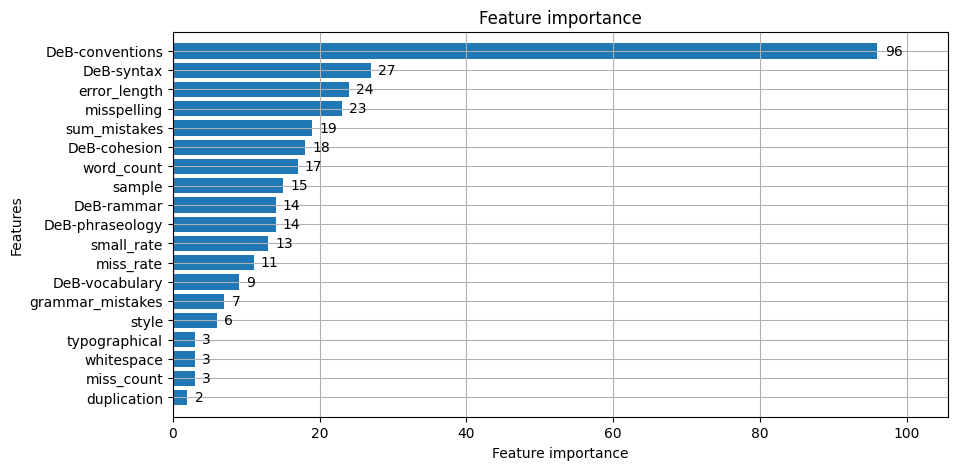

In [95]:
lgbm.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='split',)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

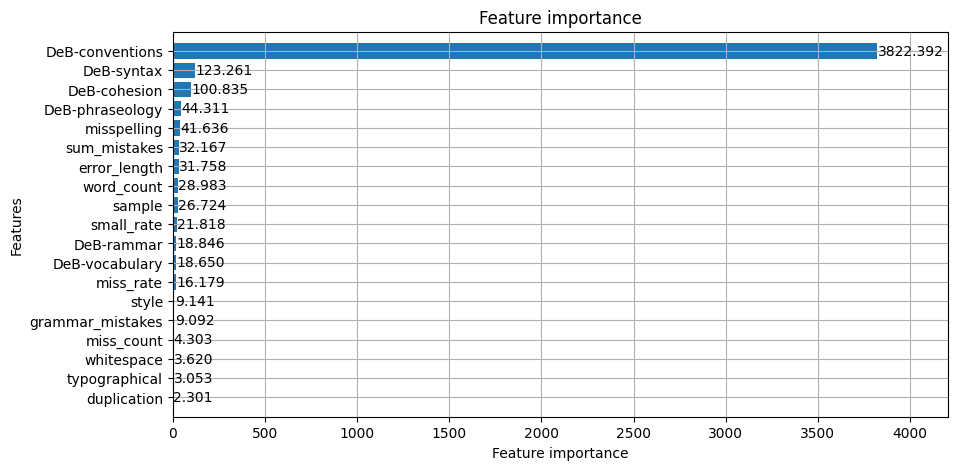

In [96]:
lgbm.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='gain',)

In [ ]:
target_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']

for i in target_list:
    print('目的変数:' + i)
    for j in range(4):
        #print('fold' + j)
        df_train = df[df.fold != j]
        df_valid = df[df.fold == j]
        
        # 学習データ
        x_train = df_train.drop(i, axis = 1)
        y_train = df_train[i]
        
        # 評価用データ
        x_valid = df_valid.drop(i, axis = 1)
        y_valid = df_valid[i]
        
        categorical_features = []
        
        #LightGBM用の訓練データセットを作成
        lgb_train = lgbm.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

        #LightGBM用の評価データセットを作成
        lgb_eval = lgbm.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)


        #ハイパーパラメータを設定
        params = {
                    'boosting_type': 'gbdt',

                    #'objective': 'binary', 二値分類
                    'objective': 'regression', #回帰
    
                    'metric':'rmse',
                    #'metric': {'l2', 'l1'}, 

                    'num_leaves': 10,
                    #'learning_rate': 0.05,
                    #'feature_fraction': 0.9,
                    #'bagging_fraction': 0.8,
                    #'bagging_freq': 5,
                    #'vervose': 0
    
                    }

        #LightGBMの学習
        lgbm_model = lgbm.train(params,
                        lgb_train,
                        valid_sets=[lgb_train,lgb_eval],
                        verbose_eval=100,
                        num_boost_round=1000,
                        early_stopping_rounds= 200
                       )
        
        y_pred = lgbm_model.predict(x_valid,num_interation=lgbm_model.best_iteration)

In [62]:
fold = 1

df_train = df2[df2.fold != fold]
df_valid = df2[df2.fold == fold]

# 学習データ
x_train = df_train.drop('target',axis = 1)
y_train = df_train['target']

# 評価用データ
x_valid = df_valid.drop('target',axis = 1)
y_valid = df_valid['target']


categorical_features = []

#LightGBM用の訓練データセットを作成
lgb_train = lgbm.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

#LightGBM用の評価データセットを作成
lgb_eval = lgbm.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)


#ハイパーパラメータを設定
params = {
    'boosting_type': 'gbdt',

    #'objective': 'binary', 二値分類
    'objective': 'regression', #回帰
    
    'metric':'rmse',
    #'metric': {'l2', 'l1'}, 

    'num_leaves': 10,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'vervose': 0
    
}

#LightGBMの学習
lgbm_model = lgbm.train(params,
                        lgb_train,
                        valid_sets=[lgb_train,lgb_eval],
                        verbose_eval=100,
                        num_boost_round=1000,
                        early_stopping_rounds= 200
                       )


#最もスコアの良いモデルの保存
optimum_boost_rounds = lgbm_model.best_iteration

#LightGBMの予測
y_pred = lgbm_model.predict(x_valid,num_interation=lgbm_model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 2934, number of used features: 26
[LightGBM] [Info] Start training from score 3.131902
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.400232	valid_1's rmse: 0.44518
[200]	training's rmse: 0.353238	valid_1's rmse: 0.449383
Early stopping, best iteration is:
[50]	training's rmse: 0.428417	valid_1's rmse: 0.443372
[LightGBM] [Warning] Unknown parameter: num_interation


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [63]:
(0.488253 + 0.443372 + 0.452601 + 0.456041)/4

0.46006674999999997

In [42]:
0.44905
0.42415
0.430138
0.413216

0.413216

In [ ]:
0.447626
0.423544
0.430148
0.415338

In [53]:
(0.444326 + 0.419902 + 0.424559 + 0.40874)/4

0.42438175